## Importations

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import io
import json
#! pip install psycopg2-binary
#! pip install boto3

## Configuration

In [2]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [3]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']),pool_recycle=600)

In [4]:
engine_dev = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DB_DEV']['username'], config['DB_DEV']['password'].replace('_percentage_', '%'), config['DB_DEV']['host'], config['DB_DEV']['port'], config['DB_DEV']['database']),pool_recycle=600)

In [5]:
providers = {'AREMA': True,
    'ARTE': False,
    'CHAPTERAUTO': True,
    'CHAPTERCMS': True,
    'CRYO': True,
    'DAILYMOTION': False,
    'DALET': True,
    'FTP': False,
    'INGESTVOD': False,
    'LIVECENTER': True,
    'NETIA': True,
    'OTHER': False,
    'PARTNERAB': False,
    'SONUMA': True,
    'VIMEO': False,
    'WHATSON': True,
    'YOUTUBE': False}

## Utilitaires

In [6]:
def export_df(df, name, date=True):
    df.to_csv('../output/{}{}.csv'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name), index=False, encoding='utf-8-sig')

In [7]:
def export_fig(plot, name, date=True):
    plot.savefig('../images/{}{}.png'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name))

## Données

### Read CSV

In [18]:
df_red = pd.read_sql_query("""select id, displaydate from article_article where date_part('year', displaydate) = '2021' and displaydate < current_date and published=1""", engine, parse_dates=['displaydate'])
df_red.head()

id         displaydate
0  10664133 2021-01-01 10:48:00
1  10664394 2021-01-01 15:09:58
2  10664437 2021-01-01 17:30:05
3  10664467 2021-01-02 07:24:00
4  10664540 2021-01-02 09:13:00

In [22]:
df_red['month'] = df_red['displaydate'].apply(lambda x: x.month)

In [24]:
months = df_red.groupby('month').count().reset_index()
months.head()

month    id  displaydate
0      1  6322         6322
1      2  5689         5689
2      3  6727         6727
3      4  5743         5743
4      5  6061         6061

<AxesSubplot:xlabel='month'>

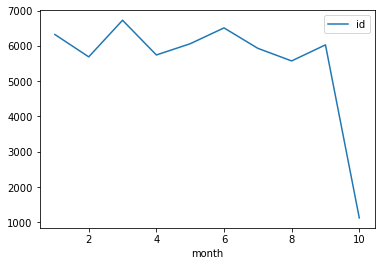

In [26]:
months.plot(x='month',y='id')

In [29]:
df_postgres = pd.read_sql_query("""SELECT id, created_date

 FROM rtbfv2.media

 WHERE created_date > '2021-01-01:00:00:00'

 AND type = 'article'""", engine_dev, parse_dates=['created_date'])
df_postgres.head()

id                     created_date
0  10842950 2021-09-16 04:45:05.566166+00:00
1  10846976 2021-09-24 12:42:48.192139+00:00
2  10842965 2021-09-16 05:42:38.121046+00:00
3  10842662 2021-09-16 05:52:41.289119+00:00
4  10841976 2021-09-16 06:49:39.001685+00:00

In [30]:
df_postgres['month'] = df_postgres['created_date'].apply(lambda x: x.month)

In [31]:
months_post = df_postgres.groupby('month').count().reset_index()
months_post.head()

month    id  created_date
0      8  9104          9104
1      9  9435          9435
2     10  1138          1138

In [32]:
months_post.plot(x='month',y='id')

<AxesSubplot:xlabel='month'>

In [35]:
df_months = months.merge(months_post, on='month', how='outer', suffixes=['_redshift','_postgres'])[['month','id_redshift','id_postgres']]
df_months.head()

month  id_redshift  id_postgres
0      1         6322          NaN
1      2         5689          NaN
2      3         6727          NaN
3      4         5743          NaN
4      5         6061          NaN

<AxesSubplot:>

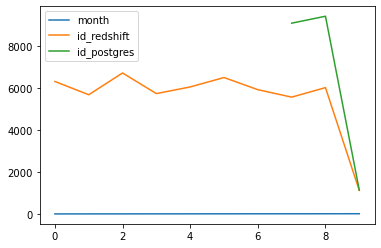

In [36]:
df_months.plot()